# Обучим модель

In [1]:
import functools

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split as tts
from sklearn import preprocessing as pr
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn import metrics
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import ensemble
from sklearn.learning_curve import learning_curve
import warnings
import xgboost as xgb
warnings.simplefilter('ignore')

%matplotlib inline

def get_numerical_features(sdata):
    features = set(sdata.columns) & set([("Var%d" % i) for i in range(1, 191)])
    return list(features)


def get_categorial_features(sdata):
    features = set(sdata.columns) & set([("Var%d" % i) for i in range(191, 231)])
    return list(features)


def get_kaggle_data():
    # считываем данные
    churn_train_data = pd.read_csv('churn_train_data.csv')
    labels = churn_train_data['labels']
    churn_train_data = churn_train_data.drop(['labels', 'ID'], axis=1)
    churn_test_data = pd.read_csv('churn_test_data.csv')
    churn_test_data = churn_test_data.drop(['ID'], axis=1)
    return churn_train_data, labels, churn_test_data


def process_numerical_features(sdata, ndata, fill_zero = None):
    features = get_numerical_features(sdata)
    for (idx, feature) in enumerate(features):
        non_na = np.array(sdata[feature].dropna())
        mean = non_na.mean()
        if fill_zero:
            sdata[feature].fillna(0, inplace=True)
            ndata[feature].fillna(0, inplace=True)
        else:
            sdata[feature].fillna(mean, inplace=True)
            ndata[feature].fillna(mean, inplace=True)

    return sdata[features].as_matrix(), ndata[features].as_matrix()


def remove_incomplete_features(sdata, ndata, features):
    to_remove = set()
    for feature in features:
        nan_part = sum(sdata[feature].isnull()) / float(sdata.shape[0])
        if nan_part > 0.9:
            sdata = sdata.drop(feature, axis=1)
            ndata = ndata.drop(feature, axis=1)
            to_remove.add(feature)    
    return sdata, ndata


def apply_str(data):
    features = get_categorial_features(data)
    for feature in features:
        data[feature] = data[feature].apply(lambda x: str(x))
    return data[features]


def one_hot(sdata, ndata):
    encoder = DV(sparse = False)
    sdata = encoder.fit_transform(sdata.T.to_dict().values())
    ndata = encoder.transform(ndata.T.to_dict().values())
    return sdata, ndata


def label_encoder(sdata, ndata):
    features = get_categorial_features(sdata)
    for feature in features:
        # применяем LabelEncoder на все строки
        encoder = pr.LabelEncoder()
        values = set(sdata[feature].values) | set(ndata[feature].values)
        encoder.fit(list(values))
        sdata[feature] = encoder.transform(sdata[feature])
        ndata[feature] = encoder.transform(ndata[feature])
    return sdata.as_matrix(), ndata.as_matrix()


def filter_drop_less(sdata, ndata, **kwargs):
    drop_less = kwargs.get('drop_less', 0)
    features = get_categorial_features(sdata)
    for feature in features:
        vcounts = sdata[feature].value_counts()
        sdata[feature] = sdata[feature].apply(lambda x: 'nan' if vcounts.get(x, 0) < drop_less else x)
        ndata[feature] = ndata[feature].apply(lambda x: 'nan' if vcounts.get(x, 0) < drop_less else x)
    return sdata, ndata


def filter_by_top(sdata, ndata, **kwargs):
    top = kwargs.get('top', 10)
    features = get_categorial_features(sdata)
    for feature in features:
        vcounts = sdata[feature].value_counts()
        vcounts = [(-vcounts[x], x) for x in vcounts.keys()]
        vcounts = sorted(vcounts, key = lambda x: x[0])
        vcounts = vcounts if len(vcounts) < top else vcounts[:top]
        vcounts = set([name for cnt, name in vcounts])
        
        sdata[feature] = sdata[feature].apply(lambda x: x if x in vcounts else 'nan')
        ndata[feature] = ndata[feature].apply(lambda x: x if x in vcounts else 'nan')
    return sdata, ndata


def process_categorial_features(sdata, ndata, filter_strategy = None, 
                                feature_encoder = None, **kwargs):
    sdata, ndata = apply_str(sdata), apply_str(ndata)
    features = get_categorial_features(sdata)
    for feature in features:
        if len(set(sdata[feature].values)) == 1:
            # удаляем постоянные признаки
            sdata = sdata.drop(feature, axis=1)
            ndata = ndata.drop(feature, axis=1)
    
    filter_method = filter_by_top if filter_strategy == 'top' else filter_drop_less
    sdata, ndata = filter_method(sdata, ndata, **kwargs)
    
    features = get_categorial_features(sdata)
    sdata, ndata = sdata[features], ndata[features]
    
    feature_encoder = one_hot if feature_encoder == 'one_hot' else label_encoder
    sdata, ndata = feature_encoder(sdata, ndata)

    return sdata, ndata


def prepare_train_data(sdata, ndata, labels, fill_zero = False, remove_incomplete = False, **kwargs):
    if remove_incomplete:
        # удаляем фичи в которых большее количество пустых ячеек
        sdata, ndata = remove_incomplete_features(sdata, ndata, list(sdata.columns))
    
    # обрабатываем численные фичи
    numerical_train_data, numerical_test_data = process_numerical_features(
        sdata, ndata, fill_zero = fill_zero)

    # обрабатываем категориальные признаки
    categorial_train_data, categorial_test_data = process_categorial_features(
        sdata, ndata, **kwargs)

    prepared_train_data = np.concatenate([
            numerical_train_data, categorial_train_data], axis=1)
    prepared_test_data = np.concatenate([
            numerical_test_data, categorial_test_data], axis=1)   
    return prepared_train_data, np.array(labels), prepared_test_data


def get_estimator(depth = 3, n_estimators = 100):
    return xgb.XGBClassifier(
        learning_rate=0.1, max_depth = 3, seed = 42, n_estimators = n_estimators, min_child_weight = 10)


def plot(xs, ys):
    plt.figure()
    plt.xlabel("Number of participants (per cent)")
    plt.ylabel("revenue")
    plt.plot(xs, ys)
    plt.show()


churn_train_data, labels, churn_test_data = get_kaggle_data()
X, y, ansX = prepare_train_data(
    churn_train_data, churn_test_data, labels, fill_zero = True,
    filter_strategy = 'drop_less', feature_encoder = 'one_hot',
    drop_less = 400)

X, y, ansX = prepare_train_data(
    churn_train_data, churn_test_data, labels, fill_zero = False,
    filter_strategy = 'drop_less', feature_encoder = 'one_hot',
    drop_less = 400)

X_train, X_test, y_train, y_test = tts(X, y, random_state = 42, train_size = 30000)
est = get_estimator(n_estimators = 100)
weights = [1 if y_train[x] == -1 else 15 for x in range(X_train.shape[0])]
est.fit(X_train, y_train, sample_weight = weights)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=10, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=42, silent=True, subsample=1)

** Базовая экономическая модель. Указываем стоимость удержания, количество участников, вероятность принятия предложения, средняя прибыль от одного абонента. **

In [16]:
def base_model(est, nX, ny, cost_of_retention, per_cent, accepted_probability, mean_revenue):
    values = est.predict_proba(nX)[:,1]
    nvl = sorted([(value, ny[idx], idx) for (idx, value) in enumerate(values)],
                 key = lambda x: -x[0])
    cnt = int((per_cent / 100.) * len(nvl))
    nvl = nvl[:cnt]
    to_spend = len(nvl) * cost_of_retention
    earn = 0
    for element in nvl:
        if element[1] == 1:
            earn += accepted_probability * mean_revenue
    return earn - to_spend

Предположим, что стоимость удержания равна нулю. Если вероятность принятия предложения 0.2, то очевидно что нужно отправить предложение максимальному числу людей, но скорее всего такая модель не реалистична:

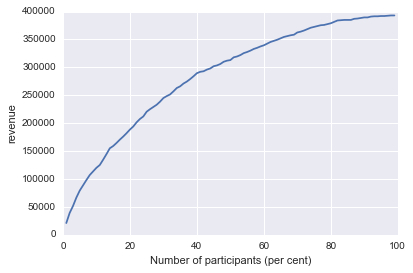

In [18]:
els = []
for per_cent in range(1, 100, 1):
    els.append(base_model(est, X_test, y_test, 0, per_cent, 0.2, 2500))
plot(range(1, 100, 1), els)

Предположим, что стоимость удержания примерно 5% средней прибыли от одного участника. Оценим экономический эффект при тех же входных данных (вероятность принятия 0.2, средняя прибыль 2500). К сожалению такая модель почти не выгодна и неоправдана:

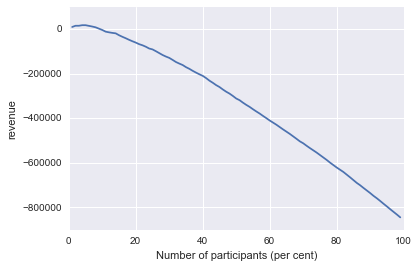

наилучшее кол. участников и полученная прибыль: 5 процентов - 16500 рублей на 10 000 участников.


In [34]:
els = []
for per_cent in range(1, 100, 1):
    els.append(base_model(est, X_test, y_test, 125, per_cent, 0.2, 2500))
plot(range(1, 100, 1), els)
res = sorted(zip(els, range(1, 100, 1)))
print(u"наилучшее кол. участников и полученная прибыль: %d процентов - %d рублей на 10 000 участников." % (res[-1][1], res[-1][0]))

Предположим, что исходя из данных прошлых акций каждый второй человек принимал условия удержания, тогда получим сл. результаты, сразу можно заметить, что акция гораздо более эффективна:

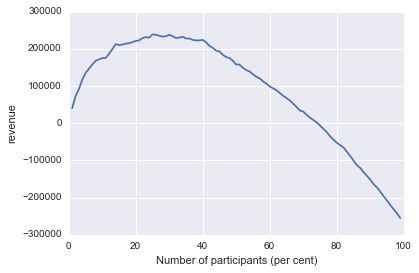

наилучшее кол. участников и полученная прибыль: 25 процентов - 238750 рублей на 10 000 участников.


In [33]:
els = []
for per_cent in range(1, 100, 1):
    els.append(base_model(est, X_test, y_test, 125, per_cent, 0.5, 2500))
plot(range(1, 100, 1), els)
res = sorted(zip(els, range(1, 100, 1)))
print(u"наилучшее кол. участников и полученная прибыль: %d процентов - %d рублей на 10 000 участников." % (res[-1][1], res[-1][0]))

Стоит отметить, что средняя телеком. компания имеет больше 100 000 000 абонентов, что принесет компании примерно 1,9 миллиарда рублей.

**Усложним модель. Пусть акция состоит в предоставлении скидки участникам. Кроме того, пользователи оттока примут участие в с меньшей вероятностью, чем не отток.**

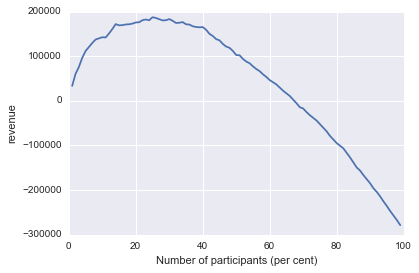

наилучшее кол. участников и полученная прибыль: 25 процентов - 187312 рублей на 10 000 участников.


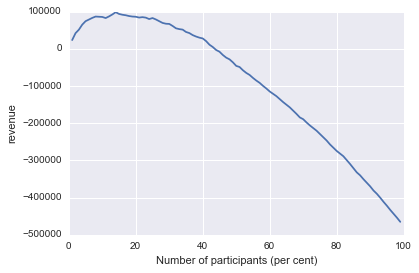

наилучшее кол. участников и полученная прибыль: 14 процентов - 98250 рублей на 10 000 участников.


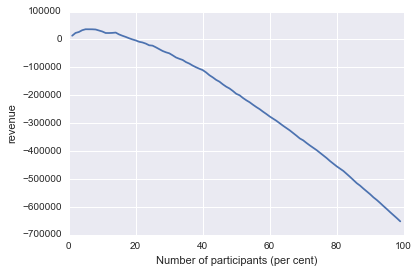

наилучшее кол. участников и полученная прибыль: 5 процентов - 36575 рублей на 10 000 участников.


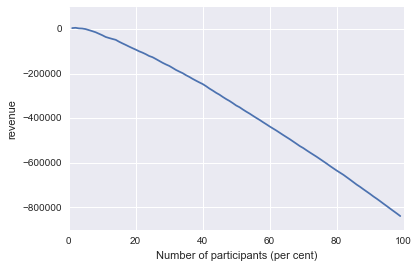

наилучшее кол. участников и полученная прибыль: 2 процентов - 4800 рублей на 10 000 участников.


In [17]:
def base_model(est, nX, ny, discount, per_cent, probability, mean_revenue):
    values = est.predict_proba(nX)[:,1]
    nvl = sorted([(value, ny[idx], idx) for (idx, value) in enumerate(values)],
                 key = lambda x: -x[0])
    cnt = int((per_cent / 100.) * len(nvl))
    nvl = nvl[:cnt]
    earn = 0
    for element in nvl:
        if element[1] == 1:
            earn += probability[1] * (mean_revenue - discount)
        else:
            earn += -probability[0] * discount
    return earn


# 40% вероятность участия в акции, в случае оттока, 90% иначе.

els = []
for per_cent in range(1, 100, 1):
    els.append(base_model(est, X_test, y_test, 125, per_cent, [0.9, 0.4], 2500))
plot(range(1, 100, 1), els)
res = sorted(zip(els, range(1, 100, 1)))
print(u"наилучшее кол. участников и полученная прибыль: %d процентов - %d рублей на 10 000 участников." % (res[-1][1], res[-1][0]))

# 40% вероятность участия в акции, в случае оттока, 90% иначе.

els = []
for per_cent in range(1, 100, 1):
    els.append(base_model(est, X_test, y_test, 125, per_cent, [0.9, 0.3], 2500))
plot(range(1, 100, 1), els)
res = sorted(zip(els, range(1, 100, 1)))
print(u"наилучшее кол. участников и полученная прибыль: %d процентов - %d рублей на 10 000 участников." % (res[-1][1], res[-1][0]))


# 20% вероятность участия в акции, в случае оттока, 90% иначе.

els = []
for per_cent in range(1, 100, 1):
    els.append(base_model(est, X_test, y_test, 125, per_cent, [0.9, 0.2], 2500))
plot(range(1, 100, 1), els)
res = sorted(zip(els, range(1, 100, 1)))
print(u"наилучшее кол. участников и полученная прибыль: %d процентов - %d рублей на 10 000 участников." % (res[-1][1], res[-1][0]))

# 10% вероятность участия в акции, в случае оттока, 90% иначе.

els = []
for per_cent in range(1, 100, 1):
    els.append(base_model(est, X_test, y_test, 125, per_cent, [0.9, 0.1], 2500))
plot(range(1, 100, 1), els)
res = sorted(zip(els, range(1, 100, 1)))
print(u"наилучшее кол. участников и полученная прибыль: %d процентов - %d рублей на 10 000 участников." % (res[-1][1], res[-1][0]))

В первом и втором случае акция может принести неплохие деньги компании, и она экономически выгодна (1,5 миллиарда рублей дохода или 800 миллионов рублей). 

В третьем случае экономическая эффективность сомнительна, хотя все еще 288 миллионов рублей. Нужно дополнительно оценивать затраты.

В четвертом случае кампания скорее всего неэффективна (32млн. доходов)

**Как вы думаете, является ли экономически оправданным вложение средств в улучшение качества модели? На сколько нужно улучшить модель, чтобы это качественно сказалось на экономическом эффекте от удержания?**

На этот вопрос стоит отвечать с учетом затрат, которые необходимы для улучшения модели. Если компания имеет штат  собственных инженеров, то улучшение может быть выгодным. Например, при затратах в 1 млн. рублей на зарплату сотрудникам за месяц можно получить 20 или 60 млн. дохода (2000 млн. рублей * 0.01 или 0.03) Также стоит учитывать другие возможные статьи дополнительного дохода, которые также могут принести дополнительный доход.

Если же компания отдает задачу на аутсорс, то скорее всего это будет не выгодно. Нужны более качественные изменения модели, как минимум 10 процентов (2000 * 0.10 = 200млн, то есть доход 200млн - стоимость контракта на улучшение модели, например 50млн. рублей)